### 준비물
아래와 같이 작업환경을 준비합시다.  


! mkdir -p ~/aiffel/face_detector/assets  
! mkdir -p ~/aiffel/face_detector/dataset  



WIDER FACE 데이터셋 홈페이지의 4개의 zip파일을 사용할 예정입니다. 사용할 WIDER_xxx.zip 파일들은 아래와 같이 구글드라이브에 올라가 있습니다.  

준비된 데이터를 연결만 해줍시다.  

! ln -s ~/data/* ~/aiffel/face_detector

https://d3s0tskafalll9.cloudfront.net/media/documents/face_detector.zip

# 데이터 전처리 분석

In [89]:
# 데이터는 4개의 디렉토리로 구분(split, test, train, val)

!cd ~/aiffel/face_detector/widerface && ls wider_face_split  WIDER_test  WIDER_train  WIDER_val

wider_face_split:
readme.txt		      wider_face_train_bbx_gt.txt  wider_face_val.mat
wider_face_test_filelist.txt  wider_face_train.mat
wider_face_test.mat	      wider_face_val_bbx_gt.txt

WIDER_test:
images

WIDER_train:
images

WIDER_val:
images


## 필요 라이브러리와 전역변수 준비

In [91]:
import os, cv2, time
import tensorflow as tf
import tqdm
import numpy as np
import math
from itertools import product
import matplotlib.pyplot as plt

PROJECT_PATH = os.getenv('HOME')+'/aiffel/face_detector'
DATA_PATH = os.path.join(PROJECT_PATH, 'widerface')
MODEL_PATH = os.path.join(PROJECT_PATH, 'checkpoints')
TRAIN_TFRECORD_PATH = os.path.join(PROJECT_PATH, 'dataset', 'train_mask.tfrecord')
VALID_TFRECORD_PATH = os.path.join(PROJECT_PATH, 'dataset', 'val_mask.tfrecord')
BEST_CHECKPOINT_PATH = os.path.join(PROJECT_PATH, 'best_checkpoint')
MODEL_SAVE_PATH = os.path.join(PROJECT_PATH, 'saved_model')

DATASET_LEN = 12880
BATCH_SIZE = 32
IMAGE_WIDTH = 320
IMAGE_HEIGHT = 256
IMAGE_LABELS = ['background', 'face']

print(tf.__version__)

2.6.0


In [90]:
# 파일 확인

!cd ~/aiffel/face_detector/widerface/wider_face_split && head -20 wider_face_train_bbx_gt.txt

0--Parade/0_Parade_marchingband_1_849.jpg
1
449 330 122 149 0 0 0 0 0 0 
0--Parade/0_Parade_Parade_0_904.jpg
1
361 98 263 339 0 0 0 0 0 0 
0--Parade/0_Parade_marchingband_1_799.jpg
21
78 221 7 8 2 0 0 0 0 0 
78 238 14 17 2 0 0 0 0 0 
113 212 11 15 2 0 0 0 0 0 
134 260 15 15 2 0 0 0 0 0 
163 250 14 17 2 0 0 0 0 0 
201 218 10 12 2 0 0 0 0 0 
182 266 15 17 2 0 0 0 0 0 
245 279 18 15 2 0 0 0 0 0 
304 265 16 17 2 0 0 0 2 1 
328 295 16 20 2 0 0 0 0 0 
389 281 17 19 2 0 0 0 2 0 
406 293 21 21 2 0 1 0 0 0 


차례로 파일명-바운딩 박스 개수-각 바운딩 박스의 값을 의미  
바운딩 박스의 값 : 449 330 122 149 0 0 0 0 0 0  
(각각의 값은 x0, y0, w, h, blur, expression, illumination, invalid, occlusion, pose에 대한 값을 의미합니다.)

각 항목의 의미

    blur: 이미지의 흐릿함(얼굴이 흐릿한 정도)을 나타냄.
        0: 선명함
        1: 약간 흐림
        2: 많이 흐림
    expression: 표정 유무나 표정의 극단성을 나타냄.
        0: 자연스러운 표정
        1: 특이하거나 과장된 표정
    illumination: 조명 상태를 나타냄.
        0: 조명이 적당하거나 정상적
        1: 조명에 의해 왜곡된 상태
    invalid: 해당 bounding box가 유효한지 여부.
        0: 유효
        1: 무효
    occlusion: 얼굴이 가려진 정도를 나타냄.
        0: 얼굴이 전혀 가려지지 않음
        1: 일부 가림
        2: 심하게 가려짐
    pose: 얼굴이 기울어진 정도나 방향.
        0: 정상적인 자세
        1: 비정상적으로 기울어진 자세

In [92]:
# bounding box 파일 분석 함수

def parse_box(data):
    x0 = int(data[0])
    y0 = int(data[1])
    w = int(data[2])
    h = int(data[3])
    return x0, y0, w, h

In [137]:
# 데이터 분석 함수
# (이미지별 bounding box 정보를 wider_face_train_bbx_gt.txt에서 파싱해서 리스트로 추출)
# 파싱(parsing)은 데이터를 특정 형식에서 원하는 형식으로 변환하거나 필요한 정보를 추출하는 과정

def parse_widerface(file):
    infos = []
    with open(file) as fp:
        line = fp.readline()
        while line:
            n_object = int(fp.readline())
            boxes = []
            for i in range(n_object):
                box = fp.readline().split(' ')
                x0, y0, w, h = parse_box(box)
                if (w == 0) or (h == 0):              # bounding box 오류일 경우 넘기기
                    continue
                boxes.append([x0, y0, w, h])
            if n_object == 0:                          # bounding box가 없는 경우 : 다음 줄을 불러와서 
                box = fp.readline().split(' ')
                x0, y0, w, h = parse_box(box)          # 빈 bounding box 값 추가?
                boxes.append([x0, y0, w, h])
            infos.append((line.strip(), boxes))
            line = fp.readline()
    return infos

In [94]:
# 이미지 처리
def process_image(image_file):
    image_string = tf.io.read_file(image_file)
    try:
        image_data = tf.image.decode_jpeg(image_string, channels=3)
        return 0, image_string, image_data
    except tf.errors.InvalidArgumentError:
        return 1, image_string, None

**process_image 함수에서 반환값 0을 포함시키는 이유?**

- 디버깅이나 예외 처리를 염두에 둔 설계
- 첫 번째 반환값을 error 변수에 저장함으로써 나중에 해당 값을 활용하거나 특정 조건(예: error != 0)을 체크

In [95]:
# 이미지 info

def xywh_to_voc(file_name, boxes, image_data):
    shape = image_data.shape
    image_info = {}
    image_info['filename'] = file_name
    image_info['width'] = shape[1]
    image_info['height'] = shape[0]
    image_info['depth'] = 3

    difficult = []
    classes = []
    xmin, ymin, xmax, ymax = [], [], [], []

    for box in boxes:
        classes.append(1)
        difficult.append(0)
        xmin.append(box[0])
        ymin.append(box[1])
        xmax.append(box[0] + box[2])
        ymax.append(box[1] + box[3])
    image_info['class'] = classes
    image_info['xmin'] = xmin
    image_info['ymin'] = ymin
    image_info['xmax'] = xmax
    image_info['ymax'] = ymax
    image_info['difficult'] = difficult

    return image_info

In [96]:
# 데이터 확인

file_path = os.path.join(DATA_PATH, 'wider_face_split', 'wider_face_train_bbx_gt.txt')
for i, info in enumerate(parse_widerface(file_path)):
    print('--------------------')
    image_file = os.path.join(DATA_PATH, 'WIDER_train', 'images', info[0])
    _, image_string, image_data = process_image(image_file)
    boxes = xywh_to_voc(image_file, info[1], image_data)
    print(boxes)
    if i > 3:
        break

--------------------
{'filename': '/aiffel/aiffel/face_detector/widerface/WIDER_train/images/0--Parade/0_Parade_marchingband_1_849.jpg', 'width': 1024, 'height': 1385, 'depth': 3, 'class': [1], 'xmin': [449], 'ymin': [330], 'xmax': [571], 'ymax': [479], 'difficult': [0]}
--------------------
{'filename': '/aiffel/aiffel/face_detector/widerface/WIDER_train/images/0--Parade/0_Parade_Parade_0_904.jpg', 'width': 1024, 'height': 1432, 'depth': 3, 'class': [1], 'xmin': [361], 'ymin': [98], 'xmax': [624], 'ymax': [437], 'difficult': [0]}
--------------------
{'filename': '/aiffel/aiffel/face_detector/widerface/WIDER_train/images/0--Parade/0_Parade_marchingband_1_799.jpg', 'width': 1024, 'height': 768, 'depth': 3, 'class': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'xmin': [78, 78, 113, 134, 163, 201, 182, 245, 304, 328, 389, 406, 436, 522, 643, 653, 793, 535, 29, 3, 20], 'ymin': [221, 238, 212, 260, 250, 218, 266, 279, 265, 295, 281, 293, 290, 328, 320, 224, 337, 311, 22

difficult는 데이터셋에서 특정 객체를 감지하기 어려운 정도를 나타내는 속성임. 예를 들어, 객체가 너무 작거나, 가려져 있거나, 이미지 배경과 유사한 경우 difficult = 1로 라벨링됨(Pascal VOC 기준).

### TFRecord 만들기  

TFRecord란 TensorFlow만의 학습 데이터 저장 포맷으로, 이진(binary) 레코드의 시퀀스를 저장합니다. TFRecord 형태의 학습 데이터를 사용하여 모델 학습을 하면 학습 속도가 개선된다는 장점이 있습니다.

In [97]:
def make_example(image_string, image_infos):
    for info in image_infos:
        filename = info['filename']
        width = info['width']
        height = info['height']
        depth = info['depth']
        classes = info['class']
        xmin = info['xmin']
        ymin = info['ymin']
        xmax = info['xmax']
        ymax = info['ymax']

    if isinstance(image_string, type(tf.constant(0))):
        encoded_image = [image_string.numpy()]
    else:
        encoded_image = [image_string]

    base_name = [tf.compat.as_bytes(os.path.basename(filename))]
    
    example = tf.train.Example(features=tf.train.Features(feature={
        'filename':tf.train.Feature(bytes_list=tf.train.BytesList(value=base_name)),
        'height':tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'width':tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'classes':tf.train.Feature(int64_list=tf.train.Int64List(value=classes)),
        'x_mins':tf.train.Feature(float_list=tf.train.FloatList(value=xmin)),
        'y_mins':tf.train.Feature(float_list=tf.train.FloatList(value=ymin)),
        'x_maxes':tf.train.Feature(float_list=tf.train.FloatList(value=xmax)),
        'y_maxes':tf.train.Feature(float_list=tf.train.FloatList(value=ymax)),
        'image_raw':tf.train.Feature(bytes_list=tf.train.BytesList(value=encoded_image))
    }))
    
    return example

In [98]:
# train, val tfrecord 생성

for split in ['train', 'val']:
    if split == 'train':
        output_file = TRAIN_TFRECORD_PATH 
        anno_txt = 'wider_face_train_bbx_gt.txt'
        file_path = 'WIDER_train'
    else:
        output_file = VALID_TFRECORD_PATH
        anno_txt = 'wider_face_val_bbx_gt.txt'
        file_path = 'WIDER_val'

    with tf.io.TFRecordWriter(output_file) as writer:
        for info in tqdm.tqdm(parse_widerface(os.path.join(DATA_PATH, 'wider_face_split', anno_txt))):
            image_file = os.path.join(DATA_PATH, file_path, 'images', info[0])
            error, image_string, image_data = process_image(image_file)
            boxes = xywh_to_voc(image_file, info[1], image_data)

            if not error:
                tf_example = make_example(image_string, [boxes])
                writer.write(tf_example.SerializeToString())

100%|██████████| 3226/3226 [00:14<00:00, 224.90it/s]


In [99]:
# 생성된 TFRecord 파일 확인

!ls ~/aiffel/face_detector/dataset

train_mask.tfrecord  val_mask.tfrecord


## 모델 구현 Default boxes

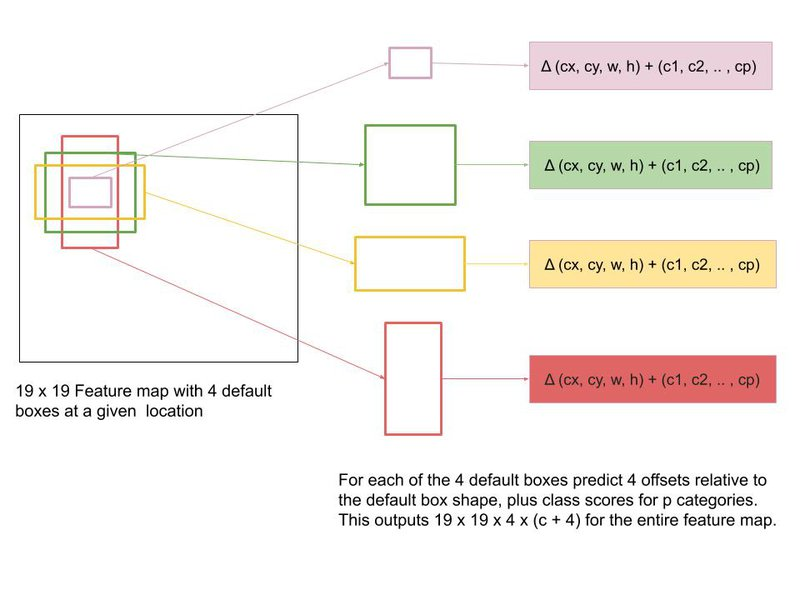

**SSD 모델의 특징 : Default box**
- Default box
    - object(instance)가 존재할 만한 다양한 크기의 box 좌표 및 클래스 정보를 일정 개수 고정해둔 것.
    - anchor box, prior box라고도 부른다
    - SSD의 default box는 층마다 생성하며 feature map에서도 box를 생성함
    - ground truth에 해당하는 bounding box와의 IoU를 계산하여 일정 비율 이상(0.5) 겹치는 default box를 선택하는 방식을 사용함
    
**Default box의 주요 정보**

- 크기(scale): Default box의 너비와 높이를 나타냄.
- 비율(aspect ratio): 가로와 세로의 비율을 정의함. 예: {1:1, 2:1, 1:2 등}.
- 좌표 정보: Default box의 중심 좌표 (x, y).
- 클래스 정보: 해당 box가 어떤 클래스에 해당하는지.

In [145]:
# default box 정보 만들기

BOX_MIN_SIZES = [[10, 16, 24], [32, 48], [64, 96], [128, 192, 256]]       # 각각의 스텝에서 사용할 기본 박스 크기들
BOX_STEPS = [8, 16, 32, 64]                                               # 각 층의 grid 크기

8x8 스텝(grid)에서는 10x10, 16x16, 24x24 크기의 박스를 사용  
16x16 스텝에서는 32x32, 48x48 크기의 박스를 사용  
32x32 스텝에서는 64x64, 96x96 크기의 박스를 사용  
64x64 스텝에서는 128x128, 192x192, 256x256 크기의 박스를 사용  

In [101]:
# 기준이 되는 feature map을 먼저 생성

image_sizes = (IMAGE_HEIGHT, IMAGE_WIDTH)
min_sizes = BOX_MIN_SIZES
steps= BOX_STEPS

feature_maps = [
    [math.ceil(image_sizes[0] / step), math.ceil(image_sizes[1] / step)]
    for step in steps
]
feature_maps

[[32, 40], [16, 20], [8, 10], [4, 5]]

In [102]:
# 각 feature map 별로 default box 생성

boxes = []
for k, f in enumerate(feature_maps):
    for i, j in product(range(f[0]), range(f[1])):
        for min_size in min_sizes[k]:
            s_kx = min_size / image_sizes[1]
            s_ky = min_size / image_sizes[0]
            cx = (j + 0.5) * steps[k] / image_sizes[1]
            cy = (i + 0.5) * steps[k] / image_sizes[0]
            boxes += [cx, cy, s_kx, s_ky]

len(boxes)

18800

In [103]:
# 생성된 boxes를 4개씩 재 배열하기 (x,y,w,h)

pretty_boxes = np.asarray(boxes).reshape([-1, 4])
print(pretty_boxes.shape)
print(pretty_boxes)

(4700, 4)
[[0.0125    0.015625  0.03125   0.0390625]
 [0.0125    0.015625  0.05      0.0625   ]
 [0.0125    0.015625  0.075     0.09375  ]
 ...
 [0.9       0.875     0.4       0.5      ]
 [0.9       0.875     0.6       0.75     ]
 [0.9       0.875     0.8       1.       ]]


모두 4700개의 default box가 만들어 졌네요. feature_maps와 min_sizes로부터 40x32x3 + 20x16x2 + 10x8x2 + 5x4x3 개가 생성되었다는 걸 확인할 수 있습니다.

In [104]:
# feature map + default box 생성 코드 함수로 구현

def default_box():
    image_sizes = (IMAGE_HEIGHT, IMAGE_WIDTH)
    min_sizes = BOX_MIN_SIZES
    steps= BOX_STEPS
    feature_maps = [
        [math.ceil(image_sizes[0] / step), math.ceil(image_sizes[1] / step)]
        for step in steps
    ]
    boxes = []
    for k, f in enumerate(feature_maps):
        for i, j in product(range(f[0]), range(f[1])):
            for min_size in min_sizes[k]:
                s_kx = min_size / image_sizes[1]
                s_ky = min_size / image_sizes[0]
                cx = (j + 0.5) * steps[k] / image_sizes[1]
                cy = (i + 0.5) * steps[k] / image_sizes[0]
                boxes += [cx, cy, s_kx, s_ky]
    boxes = np.asarray(boxes).reshape([-1, 4])
    return boxes

## SSD 모델 빌드하기

그럼 본격적으로 SSD 모델을 생성해 보겠습니다. 우선은 SSD 모델 내부에서 사용하는 레이어들을 아래와 같이 생성합니다.

일반적으로 많이 쓰이는 Convolution 블록, Depthwise Convolution 블록, 그리고 skip connection으로 쓰일 Branch 블록을 준비합니다.

In [105]:
def _conv_block(inputs, filters, kernel=(3, 3), strides=(1, 1)):
    block_id = (tf.keras.backend.get_uid())
    if strides == (2, 2):
        x = tf.keras.layers.ZeroPadding2D(padding=((1, 1), (1, 1)), name='conv_pad_%d' % block_id)(inputs)
        x = tf.keras.layers.Conv2D(filters, kernel,
                                   padding='valid',
                                   use_bias=False,
                                   strides=strides,
                                   name='conv_%d' % block_id)(x)
    else:
        x = tf.keras.layers.Conv2D(filters, kernel,
                                   padding='same',
                                   use_bias=False,
                                   strides=strides,
                                   name='conv_%d' % block_id)(inputs)
    
    x = tf.keras.layers.BatchNormalization(name='conv_bn_%d' % block_id)(x)
    return tf.keras.layers.ReLU(name='conv_relu_%d' % block_id)(x)

In [106]:
def _depthwise_conv_block(inputs, filters, strides=(1, 1)):
    block_id = tf.keras.backend.get_uid()
    if strides == (1, 1):
        x = inputs
    else:
        x = tf.keras.layers.ZeroPadding2D(((1, 1), (1, 1)), name='conv_pad_%d' % block_id)(inputs)
    x = tf.keras.layers.DepthwiseConv2D((3, 3),
                                        padding='same' if strides == (1, 1) else 'valid',
                                        strides=strides,
                                        use_bias=False,
                                        name='conv_dw_%d' % block_id)(x)
    x = tf.keras.layers.BatchNormalization(name='conv_dw_%d_bn' % block_id)(x)
    x = tf.keras.layers.ReLU(name='conv_dw_%d_relu' % block_id)(x)
    x = tf.keras.layers.Conv2D(filters, (1, 1),
                               padding='same',
                               use_bias=False,
                               strides=(1, 1),
                               name='conv_pw_%d' % block_id)(x)
    x = tf.keras.layers.BatchNormalization(name='conv_pw_%d_bn' % block_id)(x)
    return tf.keras.layers.ReLU(name='conv_pw_%d_relu' % block_id)(x)

In [107]:
def _branch_block(inputs, filters):
    x = tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), padding='same')(inputs)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), padding='same')(x)
    x1 = tf.keras.layers.Conv2D(filters * 2, kernel_size=(3, 3), padding='same')(inputs)
    x = tf.keras.layers.Concatenate(axis=-1)([x, x1])
    return tf.keras.layers.ReLU()(x)

여러 블록을 쌓아 모델을 만든 후, 중간중간 Branch 부분에 헤드(head) 라고 불리는 Convolution 레이어를 붙일 거예요. 하나의 헤드에 Convolution 레이어 두 개가 필요합니다. 하나는 confidence를 예측하기 위해 사용하고 다른 하나는 location을 예측하기 위해 사용해요.

Branch마다 헤드가 연결되어 있기 때문에 모델의 중간 레이어에서도 예측을 위한 정보를 가져올 수 있게 되었습니다.

In [108]:
def _create_head_block(inputs, filters):
    x = tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same')(inputs)
    return x

In [109]:
def _compute_heads(inputs, num_class, num_cell):
    conf = _create_head_block(inputs, num_cell * num_class)
    conf = tf.keras.layers.Reshape((-1, num_class))(conf)
    loc = _create_head_block(inputs, num_cell * 4)
    loc = tf.keras.layers.Reshape((-1, 4))(loc)
    return conf, loc

In [110]:
# SSD 모델 준비

def SsdModel():
    base_channel = 16
    num_cells = [3, 2, 2, 3]
    num_class = len(IMAGE_LABELS)
    
    x = inputs = tf.keras.layers.Input(shape=[IMAGE_HEIGHT, IMAGE_WIDTH, 3], name='input_image')

    x = _conv_block(x, base_channel, strides=(2, 2))
    x = _conv_block(x, base_channel * 2, strides=(1, 1))
    x = _conv_block(x, base_channel * 2, strides=(2, 2))
    x = _conv_block(x, base_channel * 2, strides=(1, 1))
    x = _conv_block(x, base_channel * 4, strides=(2, 2))
    x = _conv_block(x, base_channel * 4, strides=(1, 1))
    x = _conv_block(x, base_channel * 4, strides=(1, 1))
    x = _conv_block(x, base_channel * 4, strides=(1, 1))
    x1 = _branch_block(x, base_channel)

    x = _conv_block(x, base_channel * 8, strides=(2, 2))
    x = _conv_block(x, base_channel * 8, strides=(1, 1))
    x = _conv_block(x, base_channel * 8, strides=(1, 1))
    x2 = _branch_block(x, base_channel)

    x = _depthwise_conv_block(x, base_channel * 16, strides=(2, 2))
    x = _depthwise_conv_block(x, base_channel * 16, strides=(1, 1))
    x3 = _branch_block(x, base_channel)

    x = _depthwise_conv_block(x, base_channel * 16, strides=(2, 2))
    x4 = _branch_block(x, base_channel)

    extra_layers = [x1, x2, x3, x4]

    confs = []
    locs = []

    for layer, num_cell in zip(extra_layers, num_cells):
        conf, loc = _compute_heads(layer, num_class, num_cell)
        confs.append(conf)
        locs.append(loc)

    confs = tf.keras.layers.Concatenate(axis=1, name="face_classes")(confs)
    locs = tf.keras.layers.Concatenate(axis=1, name="face_boxes")(locs)

    predictions = tf.keras.layers.Concatenate(axis=2, name='predictions')([locs, confs])

    model = tf.keras.Model(inputs=inputs, outputs=predictions, name='ssd_model')
    return model

## 모델 생성

In [111]:
model = SsdModel()
print("the number of model layers: ", len(model.layers))
model.summary()

the number of model layers:  101
Model: "ssd_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 256, 320, 3) 0                                            
__________________________________________________________________________________________________
conv_pad_127 (ZeroPadding2D)    (None, 258, 322, 3)  0           input_image[0][0]                
__________________________________________________________________________________________________
conv_127 (Conv2D)               (None, 128, 160, 16) 432         conv_pad_127[0][0]               
__________________________________________________________________________________________________
conv_bn_127 (BatchNormalization (None, 128, 160, 16) 64          conv_127[0][0]                   
_________________________________________________________

## 모델 학습 (Augmentation, jaccard 적용)

Augmentation
이전 스텝에서 모델까지 구현하였습니다. 그러나 본격적으로 학습을 진행하기 전에 아직 해야할 것이 몇 가지 더 남아있습니다.

이전 스텝에서 구성한 TFRecord 형태의 데이터셋은 아직 Data augmentation이 적용되지 않았습니다. Object detection에서 사용하는 다양한 augmentation 기법을 적용해 주면 성능이 조금 더 향상될 수도 있습니다.

아래는 augmentation을 위해 tf.data.TFRecordDataset.map() 내에서 호출할 메소드들입니다.

- crop
- pad_to_square
- resize
- flip
- distort  

Image Classification에서 사용하던 함수와는 비교가 안 될 정도로 복잡한 함수들입니다. 이미지가 변경되면서 box의 위치나 크기도 함께 변경되어야 하기 때문에 함수가 복잡해질 수 밖에 없어요.

이미지를 crop했을 때 box도 함께 잘릴 수가 있어요. 함께 신경써서 잘라줍니다.

In [24]:
def _crop(img, labels, max_loop=250):
    shape = tf.shape(img)

    def matrix_iof(a, b):
        lt = tf.math.maximum(a[:, tf.newaxis, :2], b[:, :2])
        rb = tf.math.minimum(a[:, tf.newaxis, 2:], b[:, 2:])

        area_i = tf.math.reduce_prod(rb - lt, axis=2) * \
            tf.cast(tf.reduce_all(lt < rb, axis=2), tf.float32)
        area_a = tf.math.reduce_prod(a[:, 2:] - a[:, :2], axis=1)
        return area_i / tf.math.maximum(area_a[:, tf.newaxis], 1)

    def crop_loop_body(i, img, labels):
        valid_crop = tf.constant(1, tf.int32)

        pre_scale = tf.constant([0.3, 0.45, 0.6, 0.8, 1.0], dtype=tf.float32)
        scale = pre_scale[tf.random.uniform([], 0, 5, dtype=tf.int32)]
        short_side = tf.cast(tf.minimum(shape[0], shape[1]), tf.float32)
        h = w = tf.cast(scale * short_side, tf.int32)
        h_offset = tf.random.uniform([], 0, shape[0] - h + 1, dtype=tf.int32)
        w_offset = tf.random.uniform([], 0, shape[1] - w + 1, dtype=tf.int32)
        roi = tf.stack([w_offset, h_offset, w_offset + w, h_offset + h])
        roi = tf.cast(roi, tf.float32)

        value = matrix_iof(labels[:, :4], roi[tf.newaxis])
        valid_crop = tf.cond(tf.math.reduce_any(value >= 1),
                             lambda: valid_crop, lambda: 0)

        centers = (labels[:, :2] + labels[:, 2:4]) / 2
        mask_a = tf.reduce_all(
            tf.math.logical_and(roi[:2] < centers, centers < roi[2:]),
            axis=1)
        labels_t = tf.boolean_mask(labels, mask_a)
        valid_crop = tf.cond(tf.reduce_any(mask_a),
                             lambda: valid_crop, lambda: 0)

        img_t = img[h_offset:h_offset + h, w_offset:w_offset + w, :]
        h_offset = tf.cast(h_offset, tf.float32)
        w_offset = tf.cast(w_offset, tf.float32)
        labels_t = tf.stack(
            [labels_t[:, 0] - w_offset,  labels_t[:, 1] - h_offset,
             labels_t[:, 2] - w_offset,  labels_t[:, 3] - h_offset,
             labels_t[:, 4]], axis=1)

        return tf.cond(valid_crop == 1,
                       lambda: (max_loop, img_t, labels_t),
                       lambda: (i + 1, img, labels))

    _, img, labels = tf.while_loop(
        lambda i, img, labels: tf.less(i, max_loop),
        crop_loop_body,
        [tf.constant(-1), img, labels],
        shape_invariants=[tf.TensorShape([]),
                          tf.TensorShape([None, None, 3]),
                          tf.TensorShape([None, 5])])

    return img, labels

In [25]:
def _resize(img, labels):
    w_f = tf.cast(tf.shape(img)[1], tf.float32)
    h_f = tf.cast(tf.shape(img)[0], tf.float32)
    locs = tf.stack([labels[:, 0] / w_f,  labels[:, 1] / h_f,
                     labels[:, 2] / w_f,  labels[:, 3] / h_f] ,axis=1)
    locs = tf.clip_by_value(locs, 0, 1.0)
    labels = tf.concat([locs, labels[:, 4][:, tf.newaxis]], axis=1)

    resize_case = tf.random.uniform([], 0, 5, dtype=tf.int32)

    def resize(method):
        def _resize():
            #　size h,w
            return tf.image.resize(img, [IMAGE_HEIGHT, IMAGE_WIDTH], method=method, antialias=True)
        return _resize

    img = tf.case([(tf.equal(resize_case, 0), resize('bicubic')),
                   (tf.equal(resize_case, 1), resize('area')),
                   (tf.equal(resize_case, 2), resize('nearest')),
                   (tf.equal(resize_case, 3), resize('lanczos3'))],
                  default=resize('bilinear'))

    return img, labels

In [26]:
def _flip(img, labels):
    flip_case = tf.random.uniform([], 0, 2, dtype=tf.int32)

    def flip_func():
        flip_img = tf.image.flip_left_right(img)
        flip_labels = tf.stack([1 - labels[:, 2],  labels[:, 1],
                                1 - labels[:, 0],  labels[:, 3],
                                labels[:, 4]], axis=1)

        return flip_img, flip_labels

    img, labels = tf.case([(tf.equal(flip_case, 0), flip_func)],default=lambda: (img, labels))

    return img, labels

_pad_to_square는 이미지가 정사각형이 되도록 이미지 오른쪽이나 아래 방향으로 평균 색상 영역을 추가해주는 작업입니다.

다행히도 이미지 왼쪽이나 위쪽으로는 변화가 없기 때문에 box 정보는 변하지 않습니다.

In [27]:
def _pad_to_square(img):
    height = tf.shape(img)[0]
    width = tf.shape(img)[1]

    def pad_h():
        img_pad_h = tf.ones([width - height, width, 3]) * tf.reduce_mean(img, axis=[0, 1], keepdims=True)
        return tf.concat([img, img_pad_h], axis=0)

    def pad_w():
        img_pad_w = tf.ones([height, height - width, 3]) * tf.reduce_mean(img, axis=[0, 1], keepdims=True)
        return tf.concat([img, img_pad_w], axis=1)

    img = tf.case([(tf.greater(height, width), pad_w),
                   (tf.less(height, width), pad_h)], default=lambda: img)
    return img

이미지 색상 값만 바꿔주는 _distort에서도 box 정보를 바꿀 필요는 없겠네요!

In [28]:
def _distort(img):
    img = tf.image.random_brightness(img, 0.4)
    img = tf.image.random_contrast(img, 0.5, 1.5)
    img = tf.image.random_saturation(img, 0.5, 1.5)
    img = tf.image.random_hue(img, 0.1)

    return img

### Default box 적용
SSD 모델의 특이점 중 하나가 default box를 사용한다는 점을 이미 앞에서 설명하였습니다. default box 정보는 데이터셋에 반영되어야 합니다. 아래 메소드들은 default box와 bounding box 사이의 IoU, 다른 말로 자카드 유사도(자카드 지수, jaccard index)를 측정하기 위한 것입니다.

자카드 유사도는 두 집합을 통해 유사도를 측정하는 방식 중 하나로, 두 집합의 교집합을 두 집합의 합집합으로 나눕니다. 따라서 자카드 유사도는 0과 1 사이의 값을 가지며, 두 집합의 합집합과 교집합이 서로 비슷하면 1에 근접하다는 뜻입니다.

자카드 유사도의 공식은 아래와 같습니다.

자카드 유사도
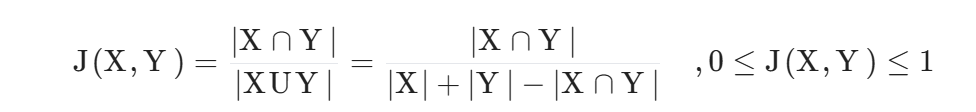

In [29]:
# 교집합 구하기

def _intersect(box_a, box_b):
    A = tf.shape(box_a)[0]
    B = tf.shape(box_b)[0]
    max_xy = tf.minimum(
        tf.broadcast_to(tf.expand_dims(box_a[:, 2:], 1), [A, B, 2]),
        tf.broadcast_to(tf.expand_dims(box_b[:, 2:], 0), [A, B, 2]))
    min_xy = tf.maximum(
        tf.broadcast_to(tf.expand_dims(box_a[:, :2], 1), [A, B, 2]),
        tf.broadcast_to(tf.expand_dims(box_b[:, :2], 0), [A, B, 2]))
    inter = tf.clip_by_value(max_xy - min_xy, 0.0, 512.0)
    return inter[:, :, 0] * inter[:, :, 1]

In [30]:
# 자카드 유사도 구하기

def _jaccard(box_a, box_b):
    inter = _intersect(box_a, box_b)
    area_a = tf.broadcast_to(
        tf.expand_dims(
            (box_a[:, 2] - box_a[:, 0]) * (box_a[:, 3] - box_a[:, 1]), 1),
        tf.shape(inter))  # [A,B]
    area_b = tf.broadcast_to(
        tf.expand_dims(
            (box_b[:, 2] - box_b[:, 0]) * (box_b[:, 3] - box_b[:, 1]), 0),
        tf.shape(inter))  # [A,B]
    union = area_a + area_b - inter
    return inter / union  # [A,B]

자카드 유사도를 계산하는 메소드가 준비되었습니다. 아래 encode_tf는 이를 이용해서 TFRecord 데이터셋의 라벨을 가공하는 메소드입니다. 내용을 정리하면 다음과 같습니다.

- jaccard 메소드를 이용해 label의 ground truth bbox와 가장 overlap 비율이 높은 matched box를 구한다.
- _encode_bbox 메소드를 통해 bbox의 scale을 동일하게 보정한다.
- 전체 default box에 대해 일정 threshold 이상 overlap되는 ground truth bounding box 존재 여부(positive/negative)를 concat하여 새로운 label로 업데이트한다.

In [31]:
def _encode_bbox(matched, boxes, variances=[0.1, 0.2]):
    g_cxcy = (matched[:, :2] + matched[:, 2:]) / 2 - boxes[:, :2]
    g_cxcy /= (variances[0] * boxes[:, 2:])
    g_wh = (matched[:, 2:] - matched[:, :2]) / boxes[:, 2:]
    g_wh = tf.math.log(g_wh) / variances[1]
    g_wh = tf.where(tf.math.is_inf(g_wh), 0.0, g_wh)
    return tf.concat([g_cxcy, g_wh], 1)

In [32]:
def encode_tf(labels, boxes):
    match_threshold = 0.45
    boxes = tf.cast(boxes, tf.float32)
    bbox = labels[:, :4]
    conf = labels[:, -1]
   
    # jaccard index
    overlaps = _jaccard(bbox, boxes)
    best_box_overlap = tf.reduce_max(overlaps, 1)
    best_box_idx = tf.argmax(overlaps, 1, tf.int32)

    best_truth_overlap = tf.reduce_max(overlaps, 0)
    best_truth_idx = tf.argmax(overlaps, 0, tf.int32)

    best_truth_overlap = tf.tensor_scatter_nd_update(
        best_truth_overlap, tf.expand_dims(best_box_idx, 1),
        tf.ones_like(best_box_idx, tf.float32) * 2.)
    best_truth_idx = tf.tensor_scatter_nd_update(
        best_truth_idx, tf.expand_dims(best_box_idx, 1),
        tf.range(tf.size(best_box_idx), dtype=tf.int32))
    # Scale Ground-Truth Boxes   
    matches_bbox = tf.gather(bbox, best_truth_idx)
    loc_t = _encode_bbox(matches_bbox, boxes)
    conf_t = tf.gather(conf, best_truth_idx)
    conf_t = tf.where(tf.less(best_truth_overlap, match_threshold), tf.zeros_like(conf_t), conf_t)

    return tf.concat([loc_t, conf_t[..., tf.newaxis]], axis=1)

load_dataset
위에서 구현한 두가지 메소드를 이전 스텝에서 생성한 tfrecord 데이터셋에 적용하여 SSD 학습을 위한 데이터셋을 생성하는 최종 메소드인 load_dataset 을 구현합니다.

- _transform_data : augmemtation과 label을 encoding 하여 기존의 dataset을 변환하는 메소드
- _parse_tfrecord : TFRecord 에 _transform_data를 적용하는 함수 클로저 생성
- load_tfrecord_dataset : tf.data.TFRecordDataset.map()에 _parse_tfrecord을 적용하는 실제 데이터셋 변환 메인 메소드
- load_dataset : load_tfrecord_dataset을 통해 train, validation 데이터셋을 생성하는 최종 메소드

In [33]:
def _transform_data(train, boxes):
    def transform_data(img, labels):
        img = tf.cast(img, tf.float32)
        if train:
            img, labels = _crop(img, labels)
            img = _pad_to_square(img)

        img, labels = _resize(img, labels)

        if train:
            img, labels = _flip(img, labels)

        if train:
            img = _distort(img)
        labels = encode_tf(labels, boxes)        
        img = img/255.0
        return img, labels
    return transform_data

In [34]:
def _parse_tfrecord(train, boxes):
    def parse_tfrecord(tfrecord):
        features = {
            'filename': tf.io.FixedLenFeature([], tf.string),
            'height': tf.io.FixedLenFeature([], tf.int64),
            'width': tf.io.FixedLenFeature([], tf.int64),
            'classes': tf.io.VarLenFeature(tf.int64),
            'x_mins': tf.io.VarLenFeature(tf.float32),
            'y_mins': tf.io.VarLenFeature(tf.float32),
            'x_maxes': tf.io.VarLenFeature(tf.float32),
            'y_maxes': tf.io.VarLenFeature(tf.float32),
            'difficult':tf.io.VarLenFeature(tf.int64),
            'image_raw': tf.io.FixedLenFeature([], tf.string),
           }

        parsed_example = tf.io.parse_single_example(tfrecord, features)
        img = tf.image.decode_jpeg(parsed_example['image_raw'], channels=3)

        width = tf.cast(parsed_example['width'], tf.float32)
        height = tf.cast(parsed_example['height'], tf.float32)

        labels = tf.sparse.to_dense(parsed_example['classes'])
        labels = tf.cast(labels, tf.float32)

        labels = tf.stack(
            [tf.sparse.to_dense(parsed_example['x_mins']),
             tf.sparse.to_dense(parsed_example['y_mins']),
             tf.sparse.to_dense(parsed_example['x_maxes']),
             tf.sparse.to_dense(parsed_example['y_maxes']),labels], axis=1)

        img, labels = _transform_data(train, boxes)(img, labels)

        return img, labels
    return parse_tfrecord

In [35]:
def load_tfrecord_dataset(tfrecord_name, train=True, boxes=None, buffer_size=1024):
    raw_dataset = tf.data.TFRecordDataset(tfrecord_name)
    raw_dataset = raw_dataset.cache()
    if train:
        raw_dataset = raw_dataset.repeat()
        raw_dataset = raw_dataset.shuffle(buffer_size=buffer_size)

    dataset = raw_dataset.map(_parse_tfrecord(train, boxes), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [36]:
def load_dataset(boxes, train=True, buffer_size=1024):
    if train:
        dataset = load_tfrecord_dataset(
            tfrecord_name=TRAIN_TFRECORD_PATH,
            train=train,
            boxes=boxes,
            buffer_size=buffer_size)
    else:
        dataset = load_tfrecord_dataset(
            tfrecord_name=VALID_TFRECORD_PATH,
            train=train,
            boxes=boxes,
            buffer_size=buffer_size)
    return dataset

## 모델 학습 (train)

**Learning rate scheduler**  

본격적으로 train에 들어가기 전에 2가지 더 준비해야 할 게 있습니다. 그중 하나는 Learning rate scheduler 입니다. 이번에는 초기시점에 WarmUp부분을 도입해 learning rate가 천천히 증가할 수 있도록 학습 스텝에 따라 다른 Learning Rate이 적용될 수 있도록 하겠습니다. PiecewiseConstantWarmUpDecay정도의 이름으로 만들어 사용할게요.

In [37]:
class PiecewiseConstantWarmUpDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, boundaries, values, warmup_steps, min_lr, name=None):
        super(PiecewiseConstantWarmUpDecay, self).__init__()

        if len(boundaries) != len(values) - 1:
            raise ValueError(
                    "The length of boundaries should be 1 less than the"
                    "length of values")

        self.boundaries = boundaries
        self.values = values
        self.name = name
        self.warmup_steps = warmup_steps
        self.min_lr = min_lr

    def __call__(self, step):
        with tf.name_scope(self.name or "PiecewiseConstantWarmUp"):
            step = tf.cast(tf.convert_to_tensor(step), tf.float32)
            pred_fn_pairs = []
            warmup_steps = self.warmup_steps
            boundaries = self.boundaries
            values = self.values
            min_lr = self.min_lr

            pred_fn_pairs.append(
                (step <= warmup_steps,
                 lambda: min_lr + step * (values[0] - min_lr) / warmup_steps))
            pred_fn_pairs.append(
                (tf.logical_and(step <= boundaries[0],
                                step > warmup_steps),
                 lambda: tf.constant(values[0])))
            pred_fn_pairs.append(
                (step > boundaries[-1], lambda: tf.constant(values[-1])))

            for low, high, v in zip(boundaries[:-1], boundaries[1:],
                                    values[1:-1]):
                pred = (step > low) & (step <= high)
                pred_fn_pairs.append((pred, lambda: tf.constant(v)))

            return tf.case(pred_fn_pairs, lambda: tf.constant(values[0]),
                           exclusive=True)

PiecewiseConstantWarmUpDecay를 편하게 사용할 수 있도록 함수를 만들어 둡니다.

In [38]:
def MultiStepWarmUpLR(initial_learning_rate, lr_steps, lr_rate,
                      warmup_steps=0., min_lr=0.,
                      name='MultiStepWarmUpLR'):
    assert warmup_steps <= lr_steps[0]
    assert min_lr <= initial_learning_rate
    lr_steps_value = [initial_learning_rate]
    for _ in range(len(lr_steps)):
        lr_steps_value.append(lr_steps_value[-1] * lr_rate)
    return PiecewiseConstantWarmUpDecay(
        boundaries=lr_steps, values=lr_steps_value, warmup_steps=warmup_steps,
        min_lr=min_lr)

**Hard negative mining**

Object Detection 모델 학습시 자주 사용되는 Hard negative mining이라는 기법이 있습니다. 학습과정에서 label은 negative인데 confidence가 높게 나오는 샘플을 재학습하면 positive와 negative의 모호한 경계선상에 분포한 false negative 오류에 강해진다는 장점이 있습니다. 실제로 confidence가 높은 샘플을 모아 training을 다시 수행하기보다는, 그런 샘플들에 대한 loss만 따로 모아 계산해주는 방식으로 반영할 수 있습니다.

Object Detection에서는 물체 영역보다 배경 영역이 훨씬 많기 십상이므로 negative 비율을 positive의 3배가 되도록 설정해 주었습니다.

아래 구현된 hard_negative_mining 메소드와, 이 메소드를 통해 얻은 샘플을 통해 얻은 localization loss를 기존의 classification loss에 추가로 반영하는 MultiBoxLoss 계산 메소드를 확인해 주세요.

In [39]:
def hard_negative_mining(loss, class_truth, neg_ratio):
    pos_idx = class_truth > 0
    num_pos = tf.math.reduce_sum(tf.cast(pos_idx, tf.int32), axis=1)
    num_neg = num_pos * neg_ratio

    rank = tf.argsort(loss, axis=1, direction='DESCENDING')
    rank = tf.argsort(rank, axis=1)
    neg_idx = rank < tf.expand_dims(num_neg, 1)

    return pos_idx, neg_idx

In [40]:
def MultiBoxLoss(num_class, neg_pos_ratio=3.0):
    def multi_loss(y_true, y_pred):
        num_batch = tf.shape(y_true)[0]
        loc_pred, class_pred = y_pred[..., :4], y_pred[..., 4:]
        loc_truth, class_truth = y_true[..., :4], tf.squeeze(y_true[..., 4:])

        cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
        temp_loss = cross_entropy(class_truth, class_pred)
        pos_idx, neg_idx = hard_negative_mining(temp_loss, class_truth, neg_pos_ratio)

        cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='sum')
        loss_class = cross_entropy(
            class_truth[tf.math.logical_or(pos_idx, neg_idx)],
            class_pred[tf.math.logical_or(pos_idx, neg_idx)])
        
        smooth_l1_loss = tf.keras.losses.Huber(reduction='sum')
        loss_loc = smooth_l1_loss(loc_truth[pos_idx],loc_pred[pos_idx])

        num_pos = tf.math.reduce_sum(tf.cast(pos_idx, tf.float32))

        loss_class = loss_class / num_pos
        loss_loc = loss_loc / num_pos
        return loss_loc, loss_class

    return multi_loss

### Training

Default box, data set 준비

In [120]:
boxes = default_box()
train_dataset = load_dataset(boxes, train=True)

Model: "ssd_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 256, 320, 3) 0                                            
__________________________________________________________________________________________________
conv_pad_211 (ZeroPadding2D)    (None, 258, 322, 3)  0           input_image[0][0]                
__________________________________________________________________________________________________
conv_211 (Conv2D)               (None, 128, 160, 16) 432         conv_pad_211[0][0]               
__________________________________________________________________________________________________
conv_bn_211 (BatchNormalization (None, 128, 160, 16) 64          conv_211[0][0]                   
__________________________________________________________________________________________

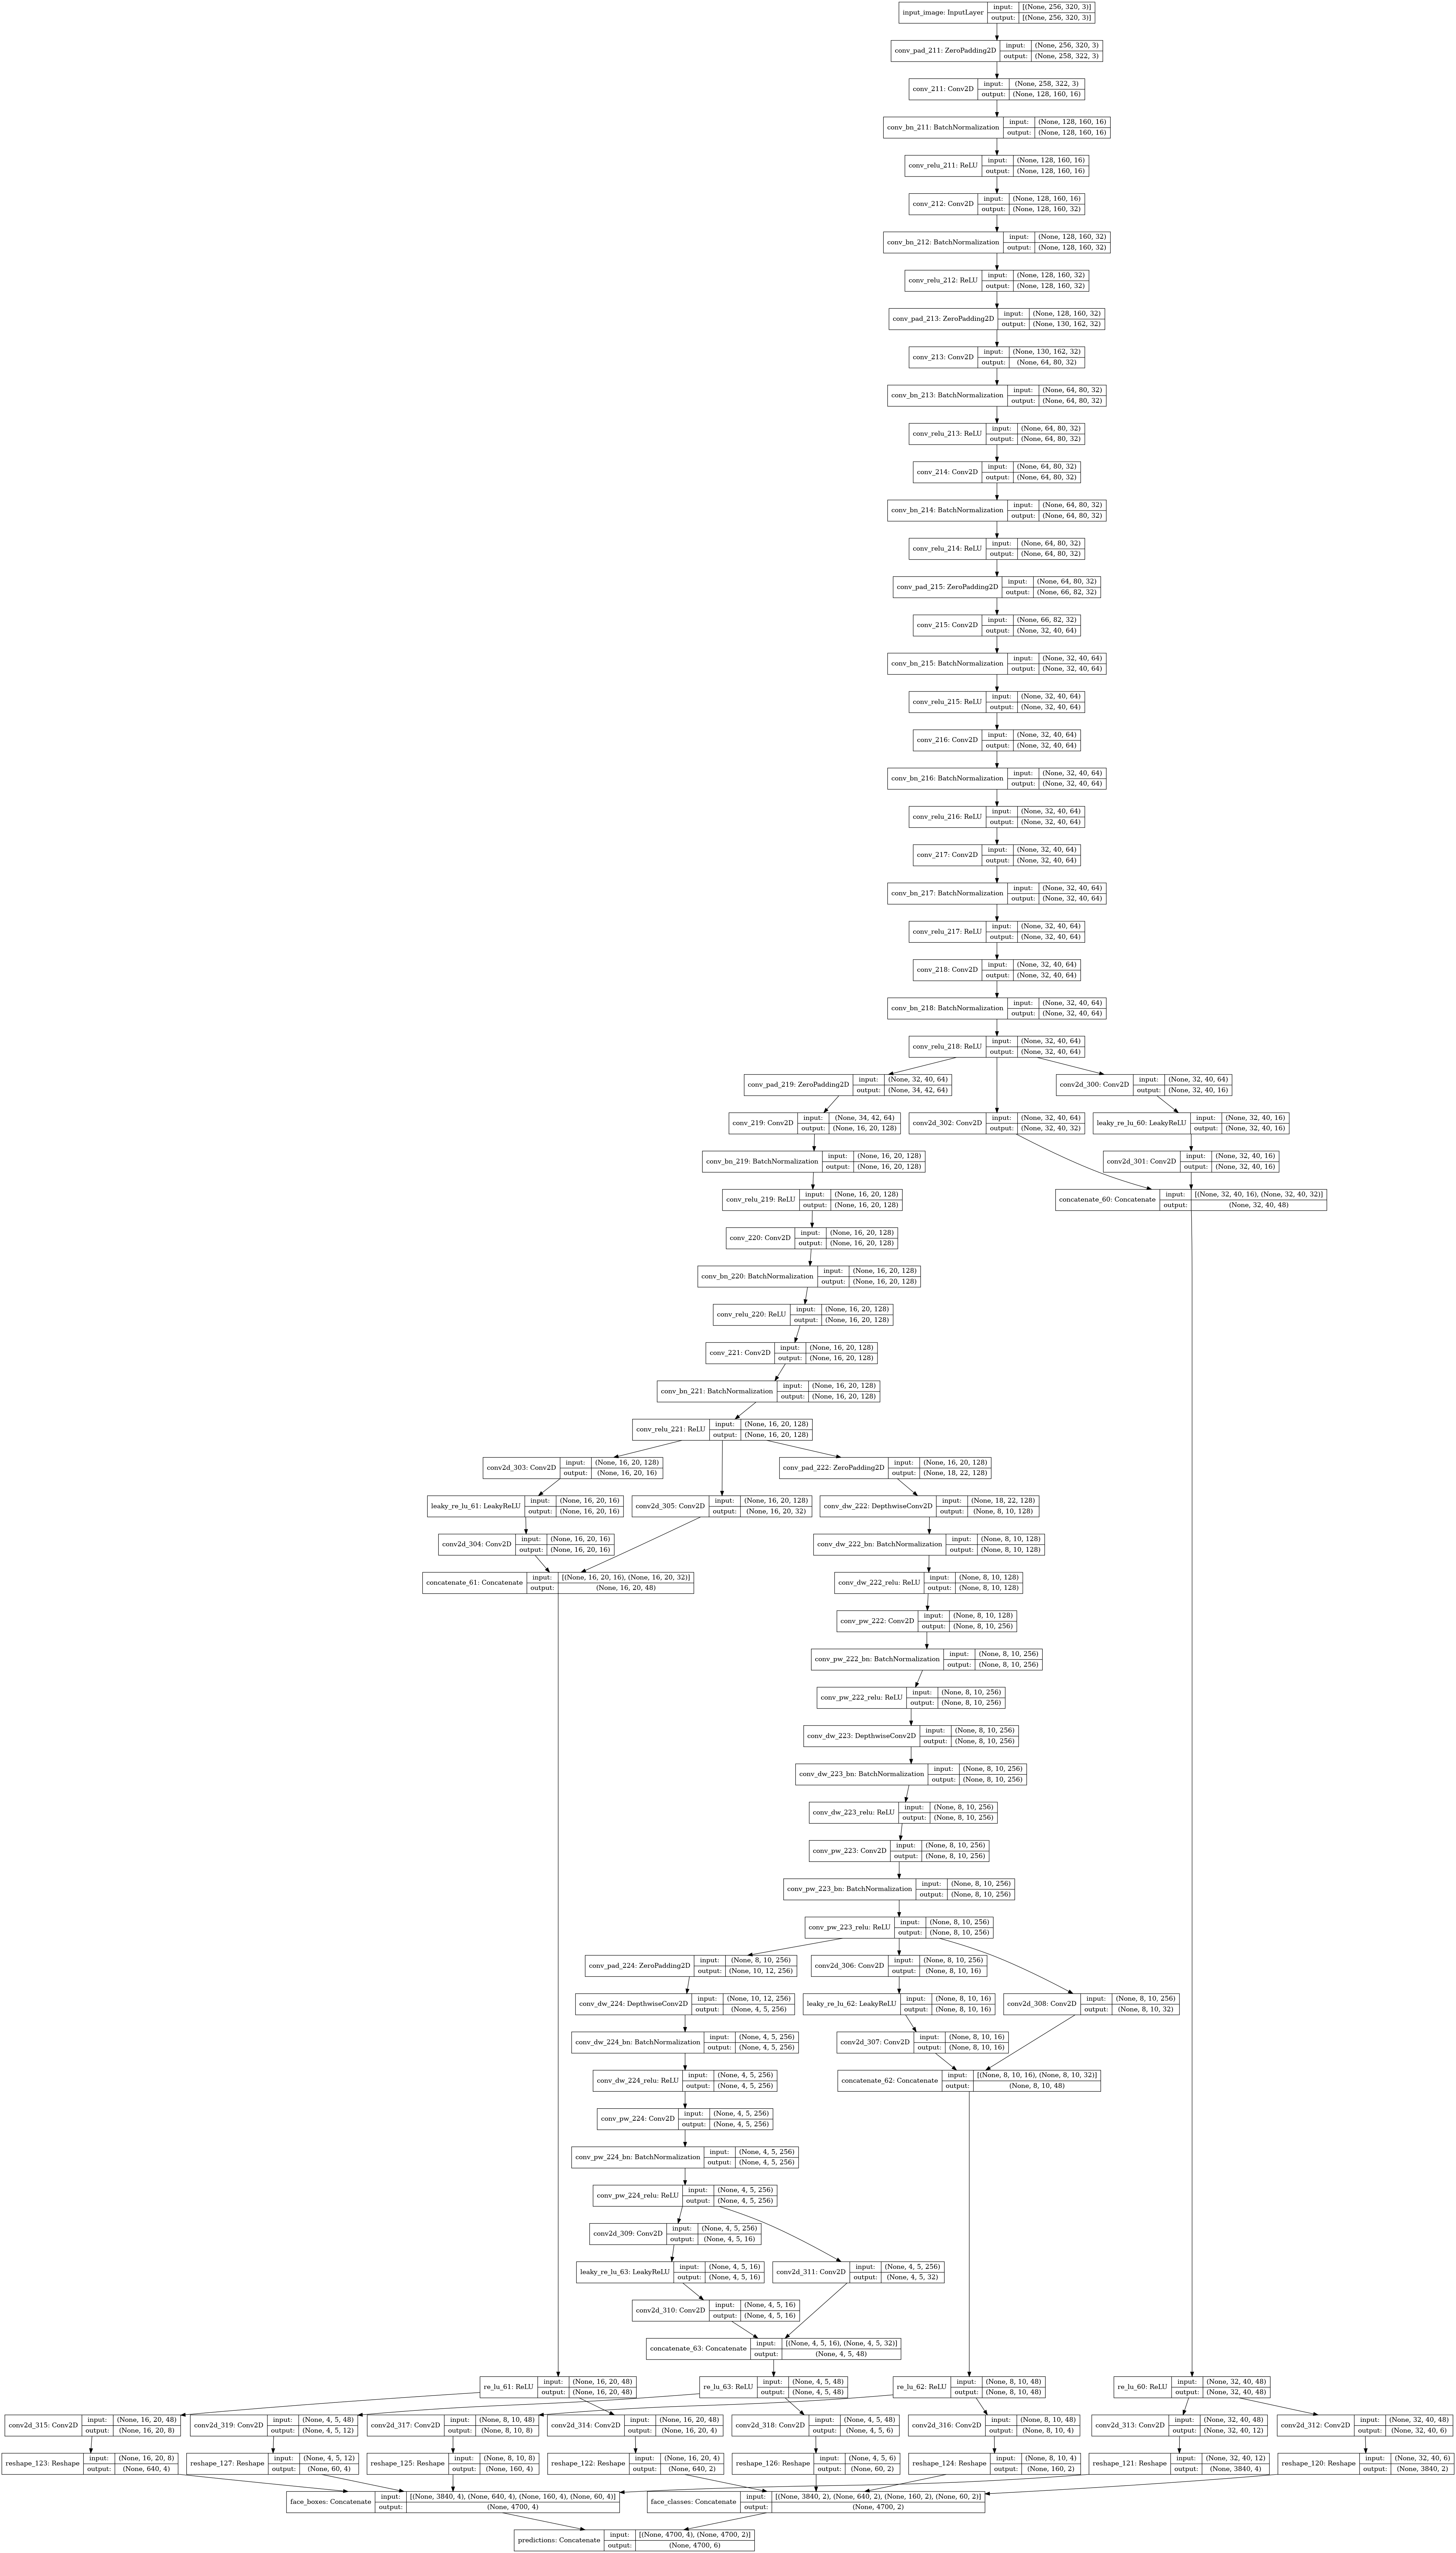

In [121]:
# 모델 생성

model = SsdModel()
model.summary()
tf.keras.utils.plot_model(
    model, 
    to_file=os.path.join(os.getcwd(), 'model.png'),  # 모델 이미지 저장
    show_shapes=True, 
    show_layer_names=True
)

In [122]:
steps_per_epoch = DATASET_LEN // BATCH_SIZE
learning_rate = MultiStepWarmUpLR(
    initial_learning_rate=1e-2,
    lr_steps=[e*steps_per_epoch for e in [50, 70]],
    lr_rate=0.1,
    warmup_steps=5*steps_per_epoch,
    min_lr=1e-4
)
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)

multi_loss = MultiBoxLoss(len(IMAGE_LABELS), neg_pos_ratio=3)

이제 학습이 진행될 함수를 작성할 차례입니다. tf.GradientTape()을 사용하는 방식에 익숙해 지셨나요? 아직 어렵다면 아래 링크를 참고하세요!

GradientTape   
https://www.tensorflow.org/api_docs/python/tf/GradientTape

Writing a training loop from scratch   
https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch

한 스텝이 학습되는 함수를 아래처럼 작성합니다.

In [123]:
@tf.function
def train_step(inputs, labels):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        losses = {}
        losses['reg'] = tf.reduce_sum(model.losses)  #unused. Init for redefine network
        losses['loc'], losses['class'] = multi_loss(labels, predictions)
        total_loss = tf.add_n([l for l in losses.values()])

    grads = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    return total_loss, losses

아래에서 본격적으로 train을 시작합니다. 100 epochs 이상 학습시켜야 좋은 성능을 보이지만 1 epoch 만 학습해 확인해 봅시다.

In [45]:
EPOCHS = 1

for epoch in range(0, EPOCHS):
    for step, (inputs, labels) in enumerate(train_dataset.take(steps_per_epoch)):
        load_t0 = time.time()
        total_loss, losses = train_step(inputs, labels)
        load_t1 = time.time()
        batch_time = load_t1 - load_t0
        print(f"\rEpoch: {epoch + 1}/{EPOCHS} | Batch {step + 1}/{steps_per_epoch} | Batch time {batch_time:.3f} || Loss: {total_loss:.6f} | loc loss:{losses['loc']:.6f} | class loss:{losses['class']:.6f} ",end = '',flush=True)

Epoch: 1/1 | Batch 402/402 | Batch time 0.076 || Loss: 6.854185 | loc loss:4.453396 | class loss:2.400789   

## NMS 구현

In [43]:
# 가장 IoU가 높은 bounding box 선택

def compute_nms(boxes, scores, nms_threshold=0.5, limit=200):
    if boxes.shape[0] == 0:
        return tf.constant([], dtype=tf.int32)
    selected = [0]
    idx = tf.argsort(scores, direction='DESCENDING')
    idx = idx[:limit]
    boxes = tf.gather(boxes, idx)

    iou = _jaccard(boxes, boxes)

    while True:
        row = iou[selected[-1]]
        next_indices = row <= nms_threshold

        iou = tf.where(
            tf.expand_dims(tf.math.logical_not(next_indices), 0),
            tf.ones_like(iou, dtype=tf.float32),
            iou
        )

        if not tf.math.reduce_any(next_indices):
            break

        selected.append(tf.argsort(
            tf.dtypes.cast(next_indices, tf.int32), direction='DESCENDING')[0].numpy())

    return tf.gather(idx, selected)

이제 모델의 예측 결과를 해석해주는 함수를 작성합니다.

아래 함수에서는 모델의 예측 결과를 디코딩해서 예측 확률을 토대로 NMS를 통해 최종 box와 score 결과를 만들어 줍니다.

In [44]:
def decode_bbox_tf(predicts, boxes, variances=[0.1, 0.2]):
    centers = boxes[:, :2] + predicts[:, :2] * variances[0] * boxes[:, 2:]
    sides = boxes[:, 2:] * tf.math.exp(predicts[:, 2:] * variances[1])
    return tf.concat([centers - sides / 2, centers + sides / 2], axis=1)

In [45]:
def parse_predict(predictions, boxes):
    label_classes = IMAGE_LABELS

    bbox_predictions, confidences = tf.split(predictions[0], [4, -1], axis=-1)
    boxes = decode_bbox_tf(bbox_predictions, boxes)

    scores = tf.math.softmax(confidences, axis=-1)

    out_boxes = []
    out_labels = []
    out_scores = []

    for c in range(1, len(label_classes)):
        cls_scores = scores[:, c]

        score_idx = cls_scores > 0.5

        cls_boxes = boxes[score_idx]
        cls_scores = cls_scores[score_idx]

        nms_idx = compute_nms(cls_boxes, cls_scores)

        cls_boxes = tf.gather(cls_boxes, nms_idx)
        cls_scores = tf.gather(cls_scores, nms_idx)

        cls_labels = [c] * cls_boxes.shape[0]

        out_boxes.append(cls_boxes)
        out_labels.extend(cls_labels)
        out_scores.append(cls_scores)

    out_boxes = tf.concat(out_boxes, axis=0)
    out_scores = tf.concat(out_scores, axis=0)

    boxes = tf.clip_by_value(out_boxes, 0.0, 1.0).numpy()
    classes = np.array(out_labels)
    scores = out_scores.numpy()

    return boxes, classes, scores

## Inference

입력할 이미지의 비율이 달라도 모델이 잘 작동할 수 있도록 이미지 패딩을 추가/제거해주는 함수를 만들어 줍니다.

In [46]:
def pad_input_image(img, max_steps):
    img_h, img_w, _ = img.shape

    img_pad_h = 0
    if img_h % max_steps > 0:
        img_pad_h = max_steps - img_h % max_steps

    img_pad_w = 0
    if img_w % max_steps > 0:
        img_pad_w = max_steps - img_w % max_steps

    padd_val = np.mean(img, axis=(0, 1)).astype(np.uint8)
    img = cv2.copyMakeBorder(img, 0, img_pad_h, 0, img_pad_w,
                             cv2.BORDER_CONSTANT, value=padd_val.tolist())
    pad_params = (img_h, img_w, img_pad_h, img_pad_w)

    return img, pad_params

In [47]:
def recover_pad(boxes, pad_params):
    img_h, img_w, img_pad_h, img_pad_w = pad_params
    box = np.reshape(boxes[0], [-1, 2, 2]) * [(img_pad_w + img_w) / img_w, (img_pad_h + img_h) / img_h]
    boxes[0] = np.reshape(box, [-1, 4])
    return boxes

아래는 최종 결과를 시각화 할 수 있도록 이미지에 box를 그려주는 함수입니다. box 사각형과 함께 확률도 표시해 줍시다.

In [48]:
def draw_box_on_face(img, boxes, classes, scores, box_index, class_list):
    img_height = img.shape[0]
    img_width = img.shape[1]

    x_min = int(boxes[box_index][0] * img_width)
    y_min = int(boxes[box_index][1] * img_height)
    x_max = int(boxes[box_index][2] * img_width)
    y_max = int(boxes[box_index][3] * img_height)

    if classes[box_index] == 1:
        color = (0, 255, 0)
    else:
        color = (0, 0, 255)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color, 2)
    
    if len(scores) > box_index :
        score = "{:.4f}".format(scores[box_index])
        class_name = class_list[classes[box_index]]
        label = '{} {}'.format(class_name, score)
        position = (x_min, y_min - 4) 
        cv2.putText(img, label, position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255))

아래 코드를 실행하여 클라우드에 저장된 테스트용 이미지의 결과를 확인해보세요.

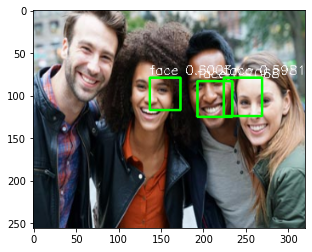

In [52]:
filepath = os.path.join(PROJECT_PATH, 'checkpoints', 'weights_epoch_008.h5')
model.load_weights(filepath)

TEST_IMAGE_PATH = os.path.join(PROJECT_PATH, 'image_people.png')

img_raw = cv2.imread(TEST_IMAGE_PATH)
img_raw = cv2.resize(img_raw, (IMAGE_WIDTH, IMAGE_HEIGHT))
img = np.float32(img_raw.copy())

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img, pad_params = pad_input_image(img, max_steps=max(BOX_STEPS))
img = img / 255.0

boxes = default_box()
boxes = tf.cast(boxes, tf.float32)

predictions = model.predict(img[np.newaxis, ...])

pred_boxes, labels, scores = parse_predict(predictions, boxes)
pred_boxes = recover_pad(pred_boxes, pad_params)

for box_index in range(len(pred_boxes)):
    draw_box_on_face(img_raw, pred_boxes, labels, scores, box_index, IMAGE_LABELS)

plt.imshow(cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB))
plt.show()

In [73]:
def img_test(img_path):

    img_raw = cv2.imread(img_path)
    img_raw = cv2.resize(img_raw, (IMAGE_WIDTH, IMAGE_HEIGHT))
    img = np.float32(img_raw.copy())

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img, pad_params = pad_input_image(img, max_steps=max(BOX_STEPS))
    img = img / 255.0

    boxes = default_box()
    boxes = tf.cast(boxes, tf.float32)

    predictions = model.predict(img[np.newaxis, ...])

    pred_boxes, labels, scores = parse_predict(predictions, boxes)
    pred_boxes = recover_pad(pred_boxes, pad_params)

    for box_index in range(len(pred_boxes)):
        draw_box_on_face(img_raw, pred_boxes, labels, scores, box_index, IMAGE_LABELS)

    plt.imshow(cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB))
    plt.show()

In [57]:
# Epochs 50으로 훈련하기

model = SsdModel()
    
EPOCHS = 50

CHECKPOINT_NEW_PATH = os.path.join(PROJECT_PATH, 'checkpoints_new')

for epoch in range(0, EPOCHS):
    for step, (inputs, labels) in enumerate(train_dataset.take(steps_per_epoch)):
        load_t0 = time.time()
        total_loss, losses = train_step(inputs, labels)
        load_t1 = time.time()
        batch_time = load_t1 - load_t0
        print(f"\rEpoch: {epoch + 1}/{EPOCHS} | Batch {step + 1}/{steps_per_epoch} | Batch time {batch_time:.3f} || Loss: {total_loss:.6f} | loc loss:{losses['loc']:.6f} | class loss:{losses['class']:.6f} ",end = '',flush=True)

        # checkpoint 저장 코드 추가
    if (epoch + 1) % 1 == 0:  # 1번마다 저장
        filepath = os.path.join(CHECKPOINT_NEW_PATH, f'weights_epoch_{(epoch + 1):03d}.h5')
        model.save_weights(filepath)
        if os.path.exists(filepath):
            print(f">>>>>>>>>>Save weights file at {filepath}<<<<<<<<<<")


Epoch: 1/50 | Batch 402/402 | Batch time 0.052 || Loss: 6.668835 | loc loss:5.324316 | class loss:1.344519 >>>>>>>>>>Save weights file at /aiffel/aiffel/face_detector/checkpoints_new/weights_epoch_001.h5<<<<<<<<<<
Epoch: 2/50 | Batch 402/402 | Batch time 0.078 || Loss: 3.147180 | loc loss:1.812095 | class loss:1.335085 >>>>>>>>>>Save weights file at /aiffel/aiffel/face_detector/checkpoints_new/weights_epoch_002.h5<<<<<<<<<<
Epoch: 3/50 | Batch 402/402 | Batch time 0.076 || Loss: 5.772745 | loc loss:4.517236 | class loss:1.255509 >>>>>>>>>>Save weights file at /aiffel/aiffel/face_detector/checkpoints_new/weights_epoch_003.h5<<<<<<<<<<
Epoch: 4/50 | Batch 402/402 | Batch time 0.071 || Loss: 4.016868 | loc loss:2.730643 | class loss:1.286225  >>>>>>>>>>Save weights file at /aiffel/aiffel/face_detector/checkpoints_new/weights_epoch_004.h5<<<<<<<<<<
Epoch: 5/50 | Batch 402/402 | Batch time 0.087 || Loss: 4.958605 | loc loss:3.723003 | class loss:1.235602 5 >>>>>>>>>>Save weights file at /ai

### 다른 이미지로 테스트하기 
얼굴 크기별로 어떻게 예측하는지 확인

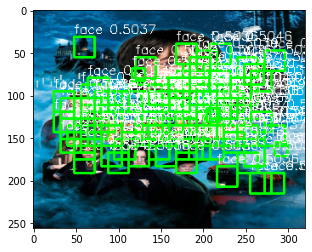

In [67]:
# loc loss가 가장 적게 나온 에폭
# Epoch: 2/50 | Batch 402/402 | Batch time 0.078 || Loss: 3.147180 | loc loss:1.812095 | class loss:1.335085

CHECKPOINT_NEW_PATH = os.path.join(PROJECT_PATH, 'checkpoints_new')

filepath = os.path.join(CHECKPOINT_NEW_PATH, 'weights_epoch_002.h5')
model.load_weights(filepath)

TEST_IMAGE_PATH = os.path.join(PROJECT_PATH, 'test_image1.jpg')

img_test(TEST_IMAGE_PATH)

얼굴을 전혀 감지하지 못함  
- 노드에서 주어진 가중치를 기반으로 재학습

## 1차 재학습

In [52]:
model = SsdModel()

filepath = os.path.join(PROJECT_PATH, 'checkpoints', 'weights_epoch_008.h5')
model.load_weights(filepath)

EPOCHS = 30
CHECKPOINT_30_PATH = os.path.join(PROJECT_PATH, 'checkpoints_30')
BEST_CHECKPOINT_PATH = os.path.join(PROJECT_PATH, 'best_checkpoint')
os.makedirs(CHECKPOINT_30_PATH, exist_ok=True)
os.makedirs(BEST_CHECKPOINT_PATH, exist_ok=True)

best_loss = float('inf')  # Best Loss 초기값

for epoch in range(0, EPOCHS):
    for step, (inputs, labels) in enumerate(train_dataset.take(steps_per_epoch)):
        load_t0 = time.time()
        total_loss, losses = train_step(inputs, labels)
        load_t1 = time.time()
        batch_time = load_t1 - load_t0
        print(f"\rEpoch: {epoch + 1}/{EPOCHS} | Batch {step + 1}/{steps_per_epoch} | Batch time {batch_time:.3f} || Loss: {total_loss:.6f} | loc loss:{losses['loc']:.6f} | class loss:{losses['class']:.6f} ", end='', flush=True)

    # Epoch마다 체크포인트 저장
    if (epoch + 1) % 1 == 0:  # 매 Epoch 저장
        filepath = os.path.join(CHECKPOINT_30_PATH, f'weights_epoch_{(epoch + 1):03d}.h5')
        model.save_weights(filepath)
        if os.path.exists(filepath):
            print(f">>>>>>>>>>Save weights file at {filepath}<<<<<<<<<<")
    
    # Best 모델 저장
    if total_loss < best_loss:
        best_loss = total_loss
        best_filepath = os.path.join(BEST_CHECKPOINT_PATH, 'best_weights.h5')
        model.save_weights(best_filepath)
        print(f"\n[Best Model] New best loss: {best_loss:.6f}. Model saved at {best_filepath}")


Epoch: 1/30 | Batch 402/402 | Batch time 0.069 || Loss: 6.129424 | loc loss:4.763950 | class loss:1.365473 >>>>>>>>>>Save weights file at /aiffel/aiffel/face_detector/checkpoints_30/weights_epoch_001.h5<<<<<<<<<<

[Best Model] New best loss: 6.129424. Model saved at /aiffel/aiffel/face_detector/best_checkpoint/best_weights.h5
Epoch: 2/30 | Batch 402/402 | Batch time 0.064 || Loss: 6.164340 | loc loss:4.688089 | class loss:1.476250 >>>>>>>>>>Save weights file at /aiffel/aiffel/face_detector/checkpoints_30/weights_epoch_002.h5<<<<<<<<<<
Epoch: 3/30 | Batch 402/402 | Batch time 0.080 || Loss: 7.273828 | loc loss:5.711292 | class loss:1.562536  >>>>>>>>>>Save weights file at /aiffel/aiffel/face_detector/checkpoints_30/weights_epoch_003.h5<<<<<<<<<<
Epoch: 4/30 | Batch 402/402 | Batch time 0.080 || Loss: 7.110693 | loc loss:5.447346 | class loss:1.663348 >>>>>>>>>>Save weights file at /aiffel/aiffel/face_detector/checkpoints_30/weights_epoch_004.h5<<<<<<<<<<
Epoch: 5/30 | Batch 402/402 | Ba

얼굴 크기별로 어떻게 예측하는지 확인

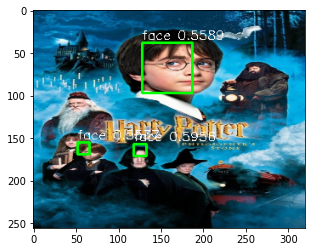

In [62]:
filepath = os.path.join(BEST_CHECKPOINT_PATH, 'best_weights.h5')
model.load_weights(filepath)

TEST_IMAGE_PATH = os.path.join(PROJECT_PATH, 'test_image1.jpg')

img_test(TEST_IMAGE_PATH)

얼굴 각도 별로 어떻게 예측하는지 확인

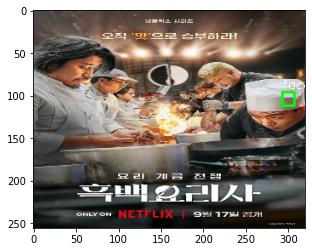

In [63]:
filepath = os.path.join(BEST_CHECKPOINT_PATH, 'best_weights.h5')
model.load_weights(filepath)

TEST_IMAGE_PATH = os.path.join(PROJECT_PATH, 'test_image2.jpg')

img_test(TEST_IMAGE_PATH)

### 결과

**best_weights:**
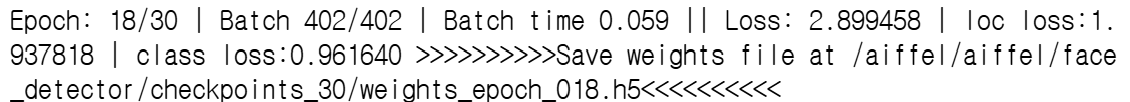
 
정면의 크게 나온 얼굴은 잘 인식하지만, 크기가 작거나 정면이 아닌 경우는 인식하지 못함  
loss가 제대로 수렴하지 않기 때문에 학습률 더 낮게 조정  

파라미터 변경  
- initial_learning_rate=1e-4로 설정
- warmup_steps=10*steps_per_epoch로 설정
- min_lr=1e-5로 설정
- SGD 대신 Adam으로 설정
- epoch 100으로 수렴하는지 확인

## 2차 재학습

In [56]:
# 모델 설정

model = SsdModel()

filepath = os.path.join(BEST_CHECKPOINT_PATH, 'best_weights.h5')
model.load_weights(filepath)

# lr 수정
steps_per_epoch = DATASET_LEN // BATCH_SIZE
learning_rate = MultiStepWarmUpLR(
    initial_learning_rate=1e-4,
    lr_steps=[e*steps_per_epoch for e in [50, 70]],
    lr_rate=0.1,
    warmup_steps=10*steps_per_epoch,
    min_lr=1e-5
)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-7)

multi_loss = MultiBoxLoss(len(IMAGE_LABELS), neg_pos_ratio=3)

@tf.function
def train_step(inputs, labels):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        losses = {}
        losses['reg'] = tf.reduce_sum(model.losses)
        losses['loc'], losses['class'] = multi_loss(labels, predictions)
        total_loss = tf.add_n([l for l in losses.values()])

    grads = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    return total_loss, losses

In [57]:
EPOCHS = 100

for epoch in range(0, EPOCHS):
    for step, (inputs, labels) in enumerate(train_dataset.take(steps_per_epoch)):
        load_t0 = time.time()
        total_loss, losses = train_step(inputs, labels)
        load_t1 = time.time()
        batch_time = load_t1 - load_t0
        print(f"\rEpoch: {epoch + 1}/{EPOCHS} | Batch {step + 1}/{steps_per_epoch} | Batch time {batch_time:.3f} || Loss: {total_loss:.6f} | loc loss:{losses['loc']:.6f} | class loss:{losses['class']:.6f} ", end='', flush=True)

    # Epoch마다 체크포인트 저장
    if (epoch + 1) % 1 == 0:  # 매 Epoch 저장
        filepath = os.path.join(CHECKPOINT_30_PATH, f'weights_epoch_{(epoch + 1):03d}.h5')
        model.save_weights(filepath)
        if os.path.exists(filepath):
            print(f">>>>>>>>>>Save weights file at {filepath}<<<<<<<<<<")
    
    # Best 모델 저장
    if total_loss < best_loss:
        best_loss = total_loss
        best_filepath = os.path.join(BEST_CHECKPOINT_PATH, 'best_weights.h5')
        model.save_weights(best_filepath)
        print(f"\n[Best Model] New best loss: {best_loss:.6f}. Model saved at {best_filepath}")


Epoch: 1/100 | Batch 402/402 | Batch time 0.055 || Loss: 7.074749 | loc loss:5.366844 | class loss:1.707906  >>>>>>>>>>Save weights file at /aiffel/aiffel/face_detector/checkpoints_30/weights_epoch_001.h5<<<<<<<<<<

[Best Model] New best loss: 7.074749. Model saved at /aiffel/aiffel/face_detector/best_checkpoint/best_weights.h5
Epoch: 2/100 | Batch 402/402 | Batch time 0.047 || Loss: 5.661969 | loc loss:4.134393 | class loss:1.527576 >>>>>>>>>>Save weights file at /aiffel/aiffel/face_detector/checkpoints_30/weights_epoch_002.h5<<<<<<<<<<

[Best Model] New best loss: 5.661969. Model saved at /aiffel/aiffel/face_detector/best_checkpoint/best_weights.h5
Epoch: 3/100 | Batch 402/402 | Batch time 0.078 || Loss: 5.395599 | loc loss:4.106275 | class loss:1.289324 >>>>>>>>>>Save weights file at /aiffel/aiffel/face_detector/checkpoints_30/weights_epoch_003.h5<<<<<<<<<<

[Best Model] New best loss: 5.395599. Model saved at /aiffel/aiffel/face_detector/best_checkpoint/best_weights.h5
Epoch: 4/100

Epoch: 72/100 | Batch 402/402 | Batch time 0.072 || Loss: 4.829226 | loc loss:3.539366 | class loss:1.289860 >>>>>>>>>>Save weights file at /aiffel/aiffel/face_detector/checkpoints_30/weights_epoch_072.h5<<<<<<<<<<
Epoch: 73/100 | Batch 402/402 | Batch time 0.073 || Loss: 4.030181 | loc loss:2.883790 | class loss:1.146392 >>>>>>>>>>Save weights file at /aiffel/aiffel/face_detector/checkpoints_30/weights_epoch_073.h5<<<<<<<<<<
Epoch: 74/100 | Batch 402/402 | Batch time 0.076 || Loss: 4.876148 | loc loss:3.765568 | class loss:1.110580  >>>>>>>>>>Save weights file at /aiffel/aiffel/face_detector/checkpoints_30/weights_epoch_074.h5<<<<<<<<<<
Epoch: 75/100 | Batch 402/402 | Batch time 0.071 || Loss: 5.585613 | loc loss:4.691167 | class loss:0.894446 >>>>>>>>>>Save weights file at /aiffel/aiffel/face_detector/checkpoints_30/weights_epoch_075.h5<<<<<<<<<<
Epoch: 76/100 | Batch 402/402 | Batch time 0.055 || Loss: 4.781077 | loc loss:3.643007 | class loss:1.138071 >>>>>>>>>>Save weights file at

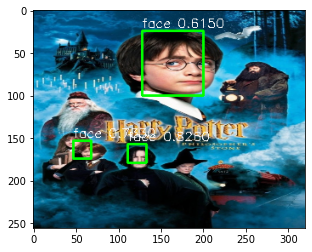

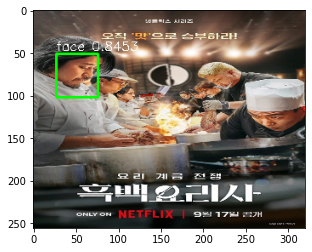

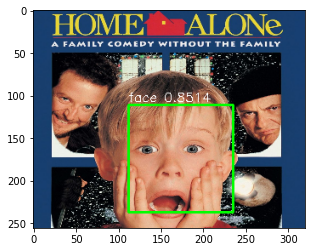

In [74]:
filepath = os.path.join(BEST_CHECKPOINT_PATH, 'best_weights.h5')
model.load_weights(filepath)

TEST_IMAGE_PATH1 = os.path.join(PROJECT_PATH, 'test_image1.jpg')
TEST_IMAGE_PATH2 = os.path.join(PROJECT_PATH, 'test_image2.jpg')
TEST_IMAGE_PATH3 = os.path.join(PROJECT_PATH, 'test_image3.jpg')

img_test(TEST_IMAGE_PATH1)
img_test(TEST_IMAGE_PATH2)
img_test(TEST_IMAGE_PATH3)

### 결과

**best_weights:**
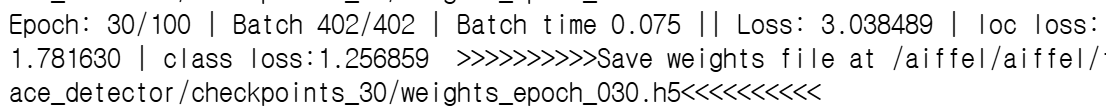

- 옆모습의 큰 이미지까지 인식, 하지만 작게 나온 이미지는 인식하지 못함
- 오류율은 1차 재학습이 더 낮지만 정성적 평가를 했을 때, 2차 재학습의 결과가 좋음  
    => total loss보다 loc loss가 더 높은 영향을 많이 주는 것으로 생각

## 3차 재학습

- loc loss를 기준으로 best loss 저장
- 학습률 더 낮춰보기

In [ ]:
# 모델 설정

model = SsdModel()

filepath = os.path.join(BEST_CHECKPOINT_PATH, 'best_weights.h5')
model.load_weights(filepath)

# lr 수정
steps_per_epoch = DATASET_LEN // BATCH_SIZE
learning_rate = MultiStepWarmUpLR(
    initial_learning_rate=1e-6,
    lr_steps=[e*steps_per_epoch for e in [50, 70]],
    lr_rate=0.01,
    warmup_steps=10*steps_per_epoch,
    min_lr=1e-7
)

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True, clipnorm=1.0)
multi_loss = MultiBoxLoss(len(IMAGE_LABELS), neg_pos_ratio=3)

@tf.function
def train_step(inputs, labels):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        losses = {}
        losses['reg'] = tf.reduce_sum(model.losses)  #unused. Init for redefine network
        losses['loc'], losses['class'] = multi_loss(labels, predictions)
        total_loss = tf.add_n([l for l in losses.values()])

    grads = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    return total_loss, losses


EPOCHS = 30

for epoch in range(0, EPOCHS):
    for step, (inputs, labels) in enumerate(train_dataset.take(steps_per_epoch)):
        load_t0 = time.time()
        total_loss, losses = train_step(inputs, labels)
        load_t1 = time.time()
        batch_time = load_t1 - load_t0
        print(f"\rEpoch: {epoch + 1}/{EPOCHS} | Batch {step + 1}/{steps_per_epoch} | Batch time {batch_time:.3f} || Loss: {total_loss:.6f} | loc loss:{losses['loc']:.6f} | class loss:{losses['class']:.6f} ", end='', flush=True)

    # Epoch마다 체크포인트 저장
    if (epoch + 1) % 1 == 0:  # 매 Epoch 저장
        filepath = os.path.join(CHECKPOINT_30_PATH, f'weights_epoch_{(epoch + 1):03d}.h5')
        model.save_weights(filepath)
        if os.path.exists(filepath):
            print(f">>>>>>>>>>Save weights file at {filepath}<<<<<<<<<<")
    
    # Best 모델 저장 (loc loss 기준)
    if losses['loc'] < best_loss:
        best_loss = losses['loc']
        best_filepath = os.path.join(BEST_CHECKPOINT_PATH, 'best_weights.h5')
        model.save_weights(best_filepath)
        print(f"\n[Best Model] New best loss: {best_loss:.6f}. Model saved at {best_filepath}")


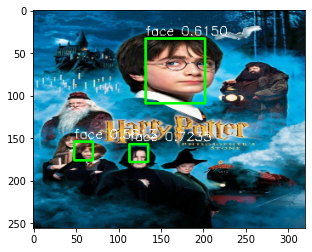

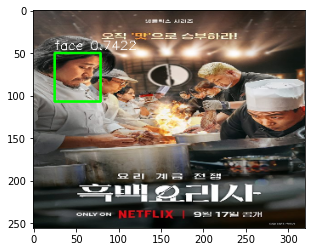

In [146]:
filepath = os.path.join(BEST_CHECKPOINT_PATH, 'best_weights.h5')
model.load_weights(filepath)

TEST_IMAGE_PATH1 = os.path.join(PROJECT_PATH, 'test_image1.jpg')
TEST_IMAGE_PATH2 = os.path.join(PROJECT_PATH, 'test_image2.jpg')

img_test(TEST_IMAGE_PATH1)
img_test(TEST_IMAGE_PATH2)

**결과**

- 로그가 사라졌지만 미세하게 loc loss 줄어듦 (1.7 -> 1.6)
- 하지만 정성적 평가로 봤을 때 차이가 없음